The global federated model is never trained on centralized data, so y_train does not exist at the server level.


Training accuracy is computed at client nodes, not at the global server; therefore it is intentionally absent from global model evaluation code.


✅ Global Model Accuracy: 71.03%


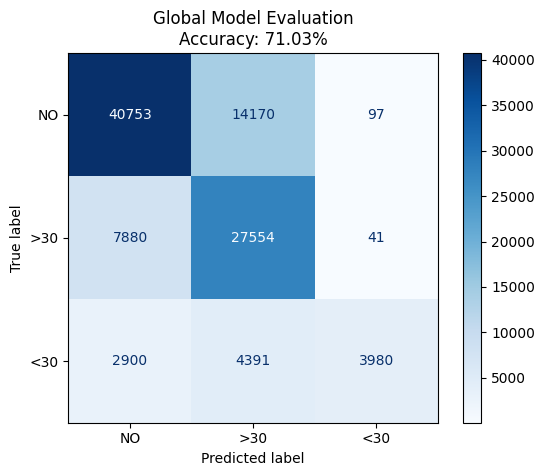

In [8]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Load the Global Model
with open("global_model.pkl", "rb") as f:
    ensemble = pickle.load(f)

models = ensemble["models"]
weights = ensemble["weights"]

# 2. Load Evaluation Data (Change path as needed)
df = pd.read_csv(r"E:\semm 8\federated_learning\federated_3\a-synthetic data\A_synthetic_diabetic_data.csv")

# 3. Quick Preprocessing
features = ['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'A1Cresult', 'max_glu_serum', 'weight']

# Minimal mapping to match model training
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1, 'Unknown/Invalid': 2}).fillna(2)
df['age'] = df['age'].map({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}).fillna(45)

for col in features:
    if df[col].dtype == 'object':
        df[col] = pd.Categorical(df[col]).codes

X = df[features].astype(float)
y_true = df["readmitted"].map({"NO": 0, ">30": 1, "<30": 2}).fillna(0).astype(int)

# 4. Ensemble Prediction (Weighted Probabilities)
final_probs = np.zeros((len(X), 3))
for model, w in zip(models, weights):
    final_probs += (model.predict_proba(X) * w)

y_pred = np.argmax(final_probs, axis=1)

# 5. Print Accuracy and Show Confusion Matrix
acc = accuracy_score(y_true, y_pred) * 100
print(f"\n✅ Global Model Accuracy: {acc:.2f}%")


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", ">30", "<30"])
disp.plot(cmap='Blues')
plt.title(f"Global Model Evaluation\nAccuracy: {acc:.2f}%")
plt.show()


🏥 global model – MODEL EVALUATION
📊 Testing Accuracy (hospital_B): 71.03%
🎯 Micro F1-score: 0.7103
🎯 Macro F1-score: 0.6525
🎯 Weighted F1-score: 0.7063
📈 AUC–ROC (Macro, OvR): 0.8761

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76     55020
           1       0.60      0.78      0.68     35475
           2       0.97      0.35      0.52     11271

    accuracy                           0.71    101766
   macro avg       0.78      0.62      0.65    101766
weighted avg       0.74      0.71      0.71    101766



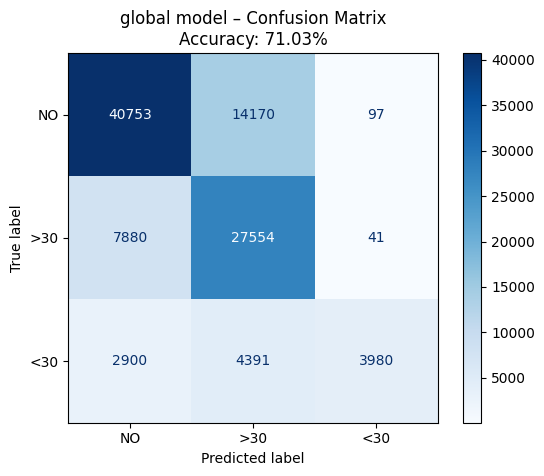

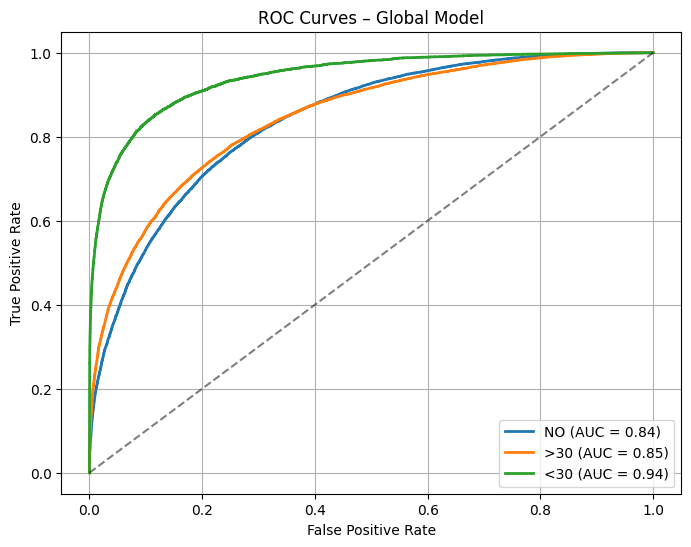

In [9]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# ---------------- LOAD GLOBAL MODEL ----------------
with open("global_model.pkl", "rb") as f:
    ensemble = pickle.load(f)

models = ensemble["models"]
weights = ensemble["weights"]

# ---------------- LOAD EVALUATION DATA ----------------
df = pd.read_csv(
    r"E:\semm 8\federated_learning\federated_3\a-synthetic data\A_synthetic_diabetic_data.csv"
)

# ---------------- FEATURES ----------------
features = [
    'race','gender','age','time_in_hospital','num_lab_procedures',
    'num_procedures','num_medications','number_outpatient',
    'number_emergency','number_inpatient','diag_1','diag_2','diag_3',
    'number_diagnoses','metformin','repaglinide','nateglinide',
    'chlorpropamide','glimepiride','acetohexamide','glipizide',
    'glyburide','tolbutamide','pioglitazone','rosiglitazone',
    'acarbose','miglitol','troglitazone','tolazamide','examide',
    'citoglipton','insulin','glyburide-metformin',
    'glipizide-metformin','glimepiride-pioglitazone',
    'metformin-rosiglitazone','metformin-pioglitazone',
    'change','diabetesMed','A1Cresult','max_glu_serum','weight'
]

# ---------------- PREPROCESSING ----------------
df['gender'] = df['gender'].map(
    {'Male': 0, 'Female': 1, 'Unknown/Invalid': 2}
).fillna(2)

df['age'] = df['age'].map({
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65,
    '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}).fillna(45)

for col in features:
    if df[col].dtype == 'object':
        df[col] = pd.Categorical(df[col]).codes

X = df[features].astype(float)
y_true = df["readmitted"].map({"NO": 0, ">30": 1, "<30": 2}).astype(int)

# ---------------- ENSEMBLE PREDICTION ----------------
final_probs = np.zeros((len(X), 3))
for model, w in zip(models, weights):
    final_probs += model.predict_proba(X) * w

y_pred = np.argmax(final_probs, axis=1)

# ---------------- METRICS ----------------
acc = accuracy_score(y_true, y_pred) * 100
micro_f1 = f1_score(y_true, y_pred, average="micro")
macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

auc_macro = roc_auc_score(
    y_true,
    final_probs,
    multi_class="ovr",
    average="macro"
)

# ---------------- PRINT RESULTS ----------------
print("\n🏥 global model – MODEL EVALUATION")
print(f"📊 Testing Accuracy (hospital_B): {acc:.2f}%")
print(f"🎯 Micro F1-score: {micro_f1:.4f}")
print(f"🎯 Macro F1-score: {macro_f1:.4f}")
print(f"🎯 Weighted F1-score: {weighted_f1:.4f}")
print(f"📈 AUC–ROC (Macro, OvR): {auc_macro:.4f}")

print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred))

# ---------------- CONFUSION MATRIX ----------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["NO", ">30", "<30"]
)
disp.plot(cmap="Blues")
plt.title(f"global model – Confusion Matrix\nAccuracy: {acc:.2f}%")
plt.show()

# ---------------- ROC CURVES (ONE-vs-REST) ----------------
y_bin = label_binarize(y_true, classes=[0, 1, 2])
class_names = ["NO", ">30", "<30"]

plt.figure(figsize=(8, 6))

for i in range(3):
    fpr, tpr, _ = roc_curve(y_bin[:, i], final_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        linewidth=2,
        label=f"{class_names[i]} (AUC = {roc_auc:.2f})"
    )

plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Global Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
